In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

path = "/content/drive/MyDrive/proyecto series de tiempo/data/"

In [36]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.3 MB/s eta 0:00:00


In [37]:
import pmdarima as pm

In [129]:
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [3]:
train = pd.read_csv(path + 'train.csv', parse_dates=['Date'])
test_series = pd.read_csv(path + 'test.csv', parse_dates=['Date'])
stores = pd.read_csv(path + 'stores.csv')
features = pd.read_csv(path + 'features.csv', parse_dates=['Date'])

In [4]:
data = train.merge(features, on=['Store', 'Date']).merge(stores, on='Store')

In [5]:
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['IsHoliday'] = data['IsHoliday_x']
data = data.drop(['IsHoliday_x', 'IsHoliday_y'], axis=1)
data = data.fillna(0)
data['Type_num'] = data['Type'].map({'A':3,'B':2,'C':1})

In [6]:
data.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Month,Year,IsHoliday,Type_num
0,1,1,2010-02-05,24924.50,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,2,2010,False,3
1,1,2,2010-02-05,50605.27,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,2,2010,False,3
2,1,3,2010-02-05,13740.12,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,2,2010,False,3
3,1,4,2010-02-05,39954.04,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,2,2010,False,3
4,1,5,2010-02-05,32229.38,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,2,2010,False,3


# Forecast

<Axes: xlabel='Date', ylabel='Weekly_Sales'>

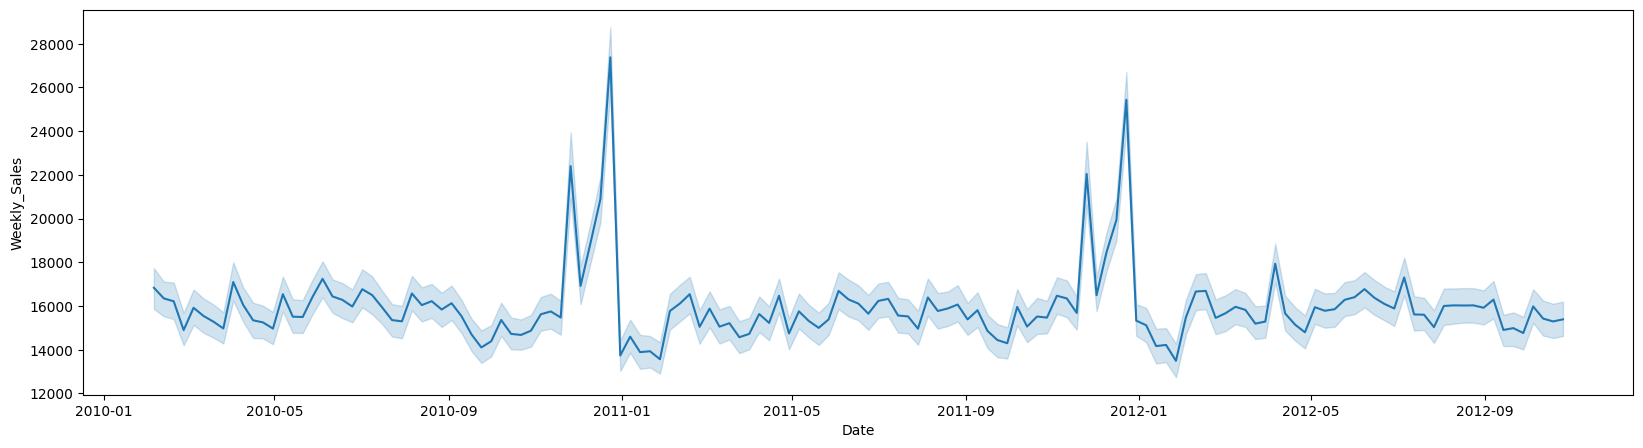

In [7]:
plt.figure(figsize=(20,5))
sns.lineplot(x='Date', y='Weekly_Sales', data=data)

Se va predecir el promedio de ganancias semanales de las tiendas reportadas en el dataset

In [8]:
time_series = data.groupby('Date',as_index=False)['Weekly_Sales'].mean().set_index('Date')

In [9]:
time_series.index.freq = 'W-FRI'

Dado que las ventas reportadas son semanales, ajustaremos la frecuencia del dataframe acorde

In [10]:
N_test = 8
train = time_series[:-N_test]
test = time_series[-N_test:]
seasonal_period = 52

Se divide el dataset en conjunto de entrenamiento y conjunto de prueba,
siendo el conjunto de prueba toda la serie de tiempo excluyendo las últimas 8 semanas, mientras que el conjunto de prueba estará conformado por las últimas 8 semanas. Visualmente la serie de tiempo alcanza sus picos máximos al final de cada año, esto nos puede ayudar a reconocer que el periodo estacional es anual, por otro lado cada observación equivale a una semana, lo que quiere decir que el periodo estacional dentro del dataset es cada 52 muestras (52 semanas en un año), dato relevante para la aplicación de modelos de predicción.

In [11]:
train_idx = time_series.index <= train.index[-1]
test_idx = time_series.index > train.index[-1]

# Holt Winters (ETS)

El primer modelo a utilizar es Exponential Smoothing con tendencia y estacionalidad aditiva.

In [13]:
modelo = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=seasonal_period)

In [14]:
resultados = modelo.fit()

In [15]:
# predicciones in-sample
in_sample_pred = resultados.fittedvalues

In [16]:
# predicciones out_of_sample
out_sample_pred = resultados.forecast(N_test)

In [17]:
time_series.loc[train_idx, 'ETS'] = in_sample_pred
time_series.loc[test_idx, 'ETS'] = out_sample_pred

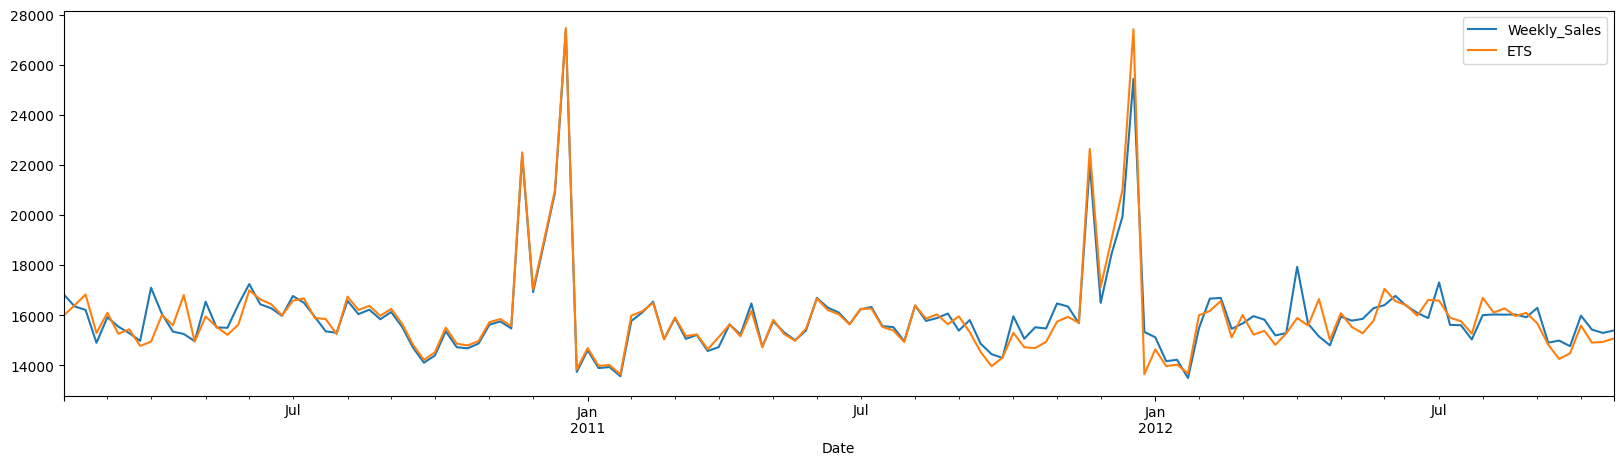

In [18]:
time_series.plot(figsize=(20,5))
plt.legend()
plt.show()

Se realiza la comparación del forecast obtenido calculando diferentes métricas de desempeño:
- Mean Absolute Error
- Root Mean Squared Error
- $R^2$

In [21]:
print("MAE (in-sample):", mean_absolute_error(time_series.loc[train_idx, 'Weekly_Sales'], time_series.loc[train_idx, 'ETS']))
print("MAE (out-sample):", mean_absolute_error(time_series.loc[test_idx, 'Weekly_Sales'], time_series.loc[test_idx, 'ETS']))

MAE (in-sample): 309.0956838154256
MAE (out-sample): 414.2389368026536


In [22]:
print("RMSE (in-sample):", np.sqrt(mean_squared_error(time_series.loc[train_idx, 'Weekly_Sales'], time_series.loc[train_idx, 'ETS'])))
print("RMSE (out-sample):", np.sqrt(mean_squared_error(time_series.loc[test_idx, 'Weekly_Sales'], time_series.loc[test_idx, 'ETS'])))

RMSE (in-sample): 506.04874901567723
RMSE (out-sample): 456.7469727997191


In [23]:
print("R2 Score (in-sample):", r2_score(time_series.loc[train_idx, 'Weekly_Sales'], time_series.loc[train_idx, 'ETS']))
print("R2 Score (out-sample):", r2_score(time_series.loc[test_idx, 'Weekly_Sales'], time_series.loc[test_idx, 'ETS']))

R2 Score (in-sample): 0.9227411295036066
R2 Score (out-sample): 0.15070718529870553


# holt winters (mul)

Se aplica el mismo modelo pero esta vez con tendencia y estacionalidad multiplicativa

In [25]:
modelo2 = ExponentialSmoothing(train['Weekly_Sales'], trend='mul', seasonal='mul', seasonal_periods=seasonal_period)

In [26]:
resultados2 = modelo2.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [27]:
# predicciones in-sample
in_sample_pred2 = resultados2.fittedvalues

In [28]:
# predicciones out_of_sample
out_sample_pred2 = resultados2.forecast(N_test)

In [29]:
time_series.loc[train_idx, 'ETS (mul)'] = in_sample_pred2
time_series.loc[test_idx, 'ETS (mul)'] = out_sample_pred2

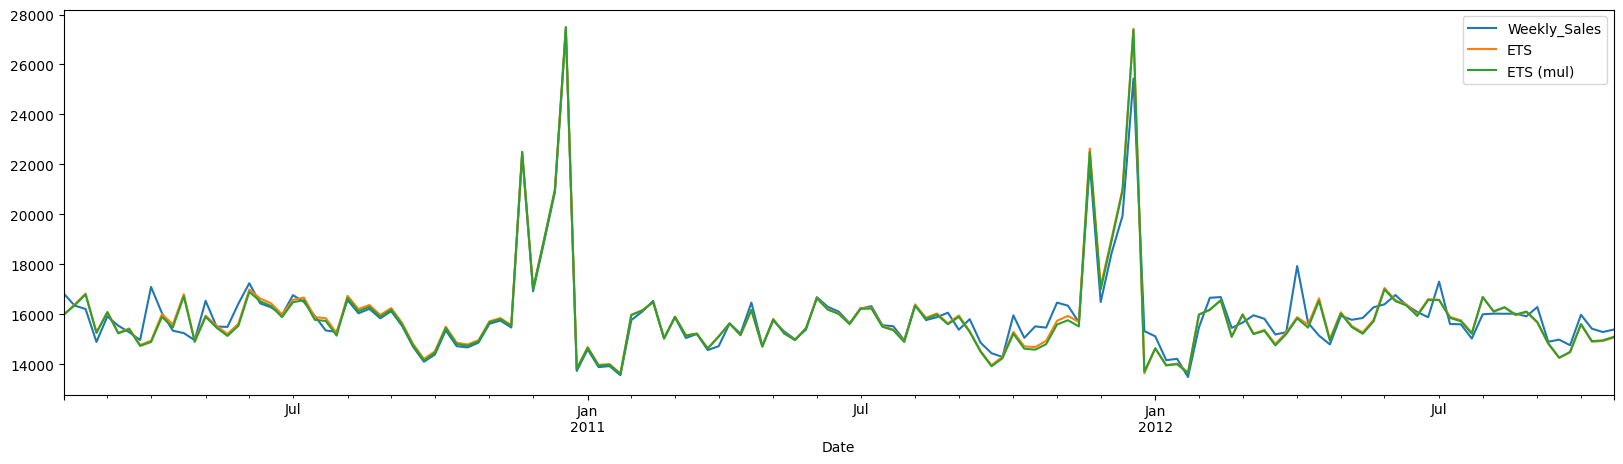

In [30]:
time_series.plot(figsize=(20,5))
plt.legend()
plt.show()

In [31]:
print("MAE (in-sample):", mean_absolute_error(time_series.loc[train_idx, 'Weekly_Sales'], time_series.loc[train_idx, 'ETS (mul)']))
print("MAE (out-sample):", mean_absolute_error(time_series.loc[test_idx, 'Weekly_Sales'], time_series.loc[test_idx, 'ETS (mul)']))

MAE (in-sample): 307.1934501543684
MAE (out-sample): 392.0594669355328


In [32]:
print("RMSE (in-sample):", np.sqrt(mean_squared_error(time_series.loc[train_idx, 'Weekly_Sales'], time_series.loc[train_idx, 'ETS (mul)'])))
print("RMSE (out-sample):", np.sqrt(mean_squared_error(time_series.loc[test_idx, 'Weekly_Sales'], time_series.loc[test_idx, 'ETS (mul)'])))

RMSE (in-sample): 505.86067826749894
RMSE (out-sample): 437.15171100078726


In [33]:
print("R2 Score (in-sample):", r2_score(time_series.loc[train_idx, 'Weekly_Sales'], time_series.loc[train_idx, 'ETS (mul)']))
print("R2 Score (out-sample):", r2_score(time_series.loc[test_idx, 'Weekly_Sales'], time_series.loc[test_idx, 'ETS (mul)']))

R2 Score (in-sample): 0.9227985446580811
R2 Score (out-sample): 0.2220163685969726


# ARIMA

Veamos si la serie de tiempo es estacionaria, para eso utilizamos la prueba de estacionaridad adfuller. Esta tiene como hipótesis nula que la serie es no estacionaria y como hipótesis alternativa que la serie es estacionaria.

In [35]:
print("p-value:",adfuller(time_series['Weekly_Sales'])[1])

p-value: 2.3832272706103574e-07


Dado que el p-value obtenido de la prueba es < 0.05, rechazamos la hipósis nula y aceptamos como verdadera la hipótesis alternativa, por lo que decimos que la serie de tiempo es estacionaria

In [38]:
modelo3 = pm.auto_arima(train,
                        trace=True,
                        supress_warnings=True,
                        seasonal=True,m=52,
                        error_action='ignore')

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=2347.536, Time=23.36 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2413.984, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2378.892, Time=7.15 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=inf, Time=10.99 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3000.742, Time=0.09 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=2362.188, Time=13.11 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=inf, Time=12.40 sec
 ARIMA(2,0,2)(2,0,1)[52] intercept   : AIC=2349.764, Time=48.74 sec
 ARIMA(2,0,2)(1,0,2)[52] intercept   : AIC=2349.515, Time=43.26 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=2402.614, Time=0.39 sec
 ARIMA(2,0,2)(0,0,2)[52] intercept   : AIC=2329.309, Time=33.21 sec
 ARIMA(1,0,2)(0,0,2)[52] intercept   : AIC=inf, Time=34.46 sec
 ARIMA(2,0,1)(0,0,2)[52] intercept   : AIC=inf, Time=32.09 sec
 ARIMA(3,0,2)(0,0,2)[52] intercept   : AIC=2356.411, Time=41.84 sec
 ARIMA(2,0,3)(0,0,2)[52] inte

In [39]:
in_sample_pred3 = modelo3.predict_in_sample()
out_sample_pred3, confint = modelo3.predict(n_periods=N_test, return_conf_int=True)

In [40]:
time_series.loc[train_idx, 'ARIMA'] = in_sample_pred3
time_series.loc[test_idx, 'ARIMA'] =out_sample_pred3

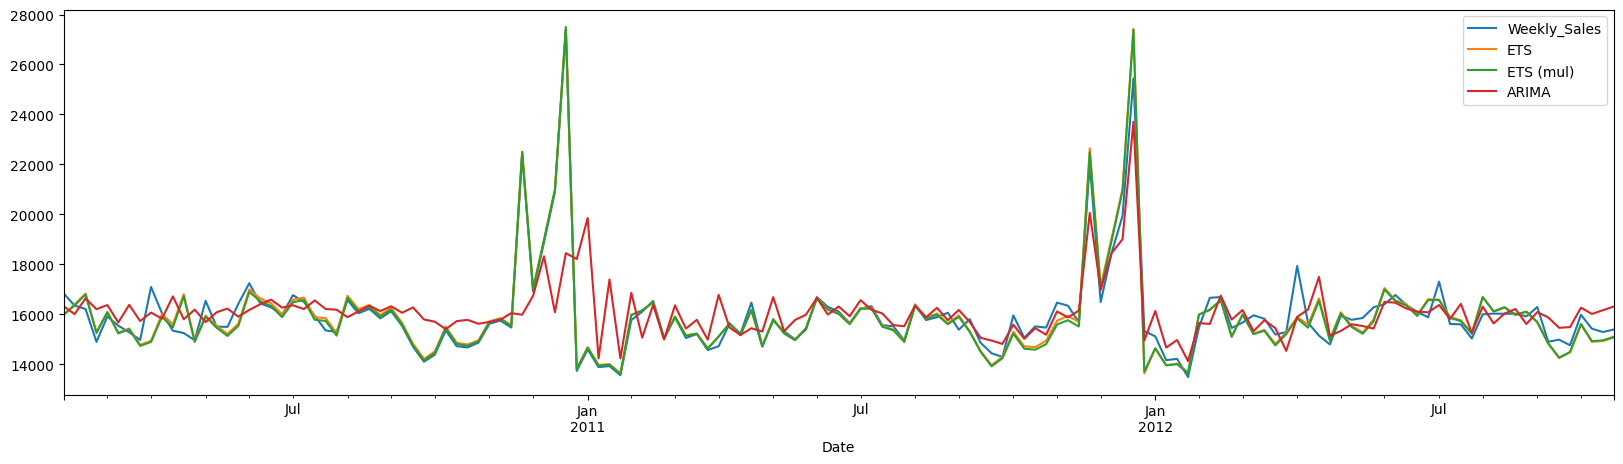

In [41]:
time_series.plot(figsize=(20,5))
plt.legend()
plt.show()

In [42]:
print("MAE (in-sample):", mean_absolute_error(time_series.loc[train_idx, 'Weekly_Sales'], time_series.loc[train_idx, 'ARIMA']))
print("MAE (out-sample):", mean_absolute_error(time_series.loc[test_idx, 'Weekly_Sales'], time_series.loc[test_idx, 'ARIMA']))

MAE (in-sample): 765.8616532341988
MAE (out-sample): 630.7278965365979


In [43]:
print("RMSE (in-sample):", np.sqrt(mean_squared_error(time_series.loc[train_idx, 'Weekly_Sales'], time_series.loc[train_idx, 'ARIMA'])))
print("RMSE (out-sample):", np.sqrt(mean_squared_error(time_series.loc[test_idx, 'Weekly_Sales'], time_series.loc[test_idx, 'ARIMA'])))

RMSE (in-sample): 1415.0132819639364
RMSE (out-sample): 687.2193926403592


In [44]:
print("R2 Score (in-sample):", r2_score(time_series.loc[train_idx, 'Weekly_Sales'], time_series.loc[train_idx, 'ARIMA']))
print("R2 Score (out-sample):", r2_score(time_series.loc[test_idx, 'Weekly_Sales'], time_series.loc[test_idx, 'ARIMA']))

R2 Score (in-sample): 0.3959336048562361
R2 Score (out-sample): -0.9226352798502186


Al comparar los resultados obtenidos tanto de forma númerica observando los resultados de la funciones de error y $R^2$, así como de manera visual se puede llegar a la conclusión de que los modelos ETS son los que modelan de mejor forma la serie de tiempo